# Fault Detection Model Trial Notebook

In [1]:
import sys
import os
import torch

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

## Load data

In [2]:
from data.prep import DataPreprocessor
from data.config import DataConfig

data_config = DataConfig(run_type='train')
data_preprocessor = DataPreprocessor("fault_detection")

# Load the data
train_data, test_data, _, = data_preprocessor.get_training_data_package(data_config)

# unpack data_loaders and data_stats
train_loader = train_data[0]
test_loader = test_data[0]

train_data_stats = train_data[1]
test_data_stats = test_data[1]


Total samples: 332, 
Train: 265 [OK=265, NOK=0, UK=0], Test: 66 [OK=66, NOK=0, UK=0], Val: 0 [OK=0, NOK=0, UK=0], 
Remainder: 1 [OK=1, NOK=0, UK=0]


In [3]:
print(f"mean: {train_data_stats['mean']}, shape: {train_data_stats['mean'].shape}")
print(f"std: {train_data_stats['std']}, shape: {train_data_stats['std'].shape}")
print(f"min: {train_data_stats['min']}, shape: {train_data_stats['min'].shape}")
print(f"max: {train_data_stats['max']}, shape: {train_data_stats['max'].shape}")

mean: tensor([[[-0.0012,  0.0020, -0.0022]],

        [[ 0.0004,  0.0014, -0.0044]],

        [[-0.0002,  0.0017, -0.0033]],

        [[-0.0073,  0.0014, -0.0052]]]), shape: torch.Size([4, 1, 3])
std: tensor([[[0.0477, 0.0942, 0.0546]],

        [[0.0391, 0.1415, 0.0529]],

        [[0.0382, 0.1759, 0.0537]],

        [[0.7168, 0.2080, 0.1317]]]), shape: torch.Size([4, 1, 3])
min: tensor([[[-0.1066, -0.1838, -0.1298]],

        [[-0.0903, -0.2605, -0.1246]],

        [[-0.0900, -0.2870, -0.0809]],

        [[-1.0972, -0.3842, -0.2921]]]), shape: torch.Size([4, 1, 3])
max: tensor([[[0.1106, 0.2104, 0.1070]],

        [[0.0876, 0.2699, 0.1065]],

        [[0.0890, 0.2806, 0.1246]],

        [[1.0901, 0.4024, 0.3126]]]), shape: torch.Size([4, 1, 3])


### Process input data

In [4]:
dataiter = iter(train_loader)
data = next(dataiter)

n_nodes = data[0].shape[1]
n_timesteps = data[0].shape[2]
n_dims = data[0].shape[3]

print(f"Number of nodes: {n_nodes}")
print(f"Number of components: {n_timesteps}")  
print(f"Number of dimensions: {n_dims}")

Number of nodes: 4
Number of components: 600
Number of dimensions: 3


## Load model

In [5]:
# load model configuration
from settings.manager import AnomalyDetectorTrainManager
from detector import AnomalyDetector

# load model configuration
fdet_config = AnomalyDetectorTrainManager(data_config)

# load anomaly detector
anomaly_detector = AnomalyDetector(fdet_config.anom_config)

In [6]:
import inspect

req_run_params = inspect.signature(anomaly_detector.set_run_params).parameters.keys()
run_config = {key: value for key, value in fdet_config.__dict__.items() if key in req_run_params}

anomaly_detector.set_run_params(**run_config, data_stats=train_data_stats)

# print model info
print("Anomaly Detector Model Initialized with the following configurations:")
anomaly_detector.print_model_info()

Anomaly Detector Model Initialized with the following configurations:
Model type: IsolationForest
Number of trees in the forest: 1000


## Train Model

In [7]:
from detector import TrainerAnomalyDetector
from torch.utils.tensorboard import SummaryWriter
from pytorch_lightning.loggers import TensorBoardLogger

n_comp, n_dims = TrainerAnomalyDetector().process_input_data(anomaly_detector, train_loader, get_data_shape=True)

train_log_path = fdet_config.get_train_log_path(n_comp, n_dims)

# if logging enabled, save parameters and initialize TensorBoard logger
if fdet_config.is_log:
    fdet_config.save_params()
    train_logger = SummaryWriter(log_dir=train_log_path)
    formatted_params = "\n".join([f"{key}: {value}" for key, value in fdet_config.__dict__.items()])
    train_logger.add_text(os.path.basename(train_log_path), formatted_params)

    sanitized_dict = {
    key: (value if isinstance(value, (int, float, bool, torch.Tensor)) else str(value))
    for key, value in fdet_config.__dict__.items()
    }

else:
    train_logger = None

# train the anomaly detector
trainer = TrainerAnomalyDetector(logger=train_logger, hparams=sanitized_dict)
trainer.fit(anomaly_detector, train_loader)

Model parameters saved to 
c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\mass_sp_dm\M004\scene_1\train\(ALL)\(ALL)_f
ault_detector_1.

ValueError: Length of values (250) does not match length of index (1000)

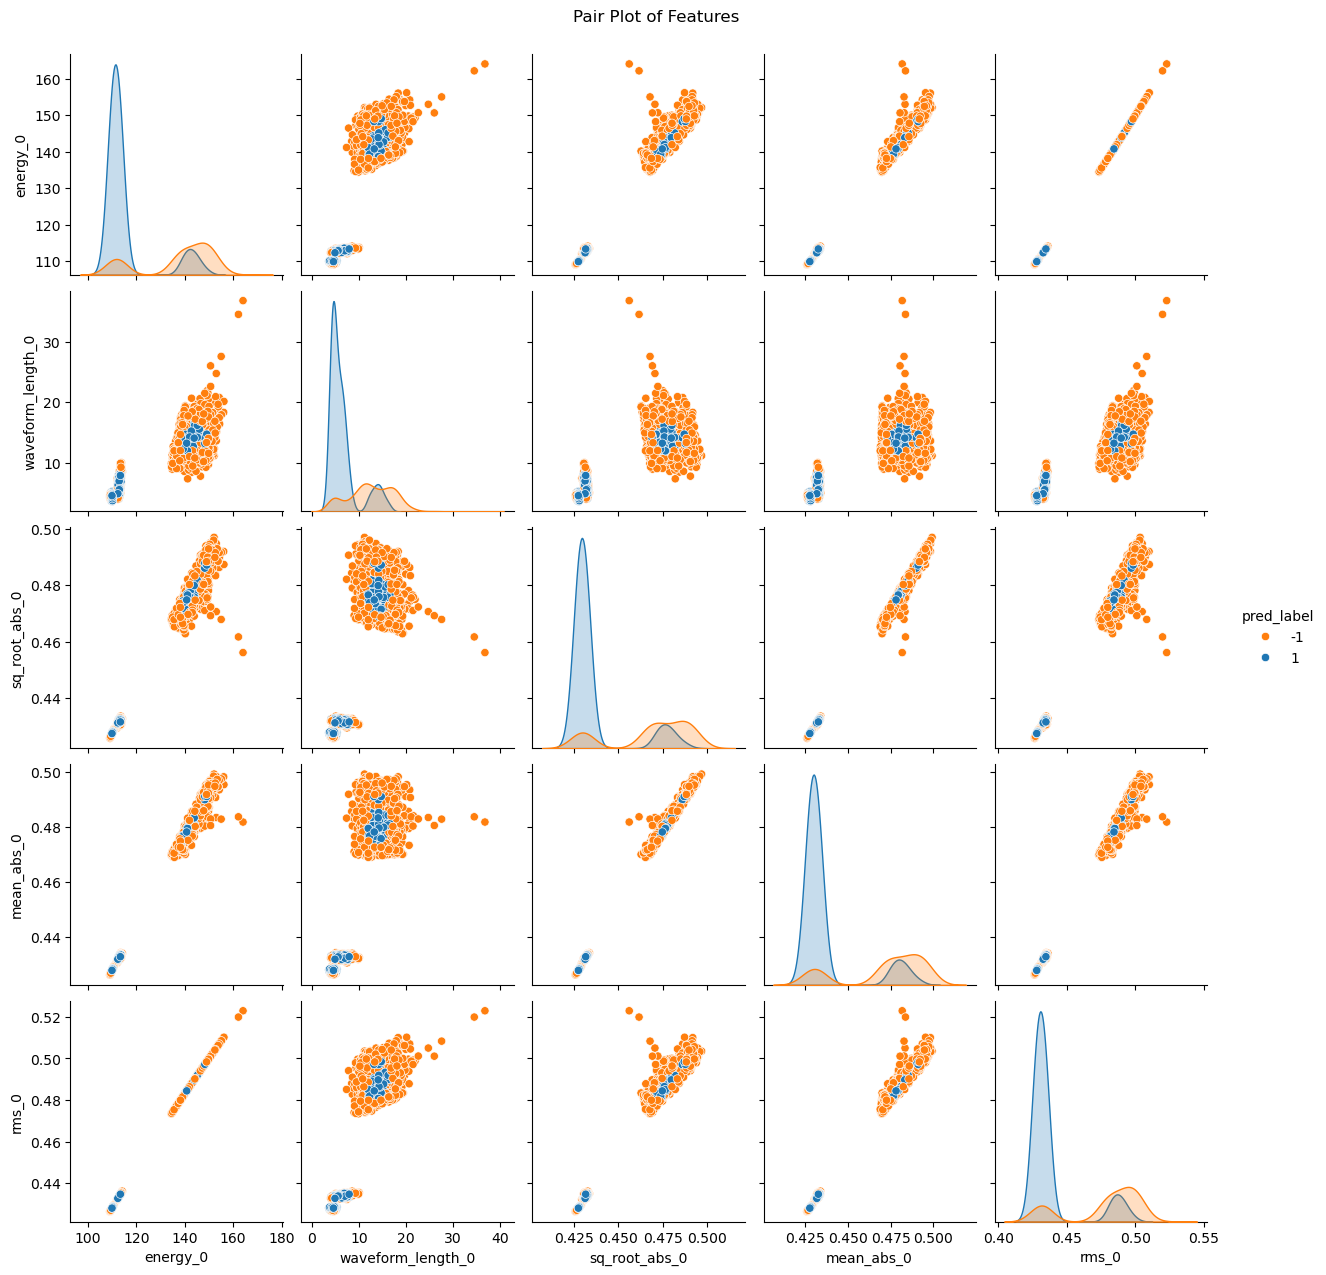


Pair plot logged at c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\CWRU\scene_1\train\(gearbox)\(gearbox)_fault_detector_3


In [8]:
trainer.pair_plot()

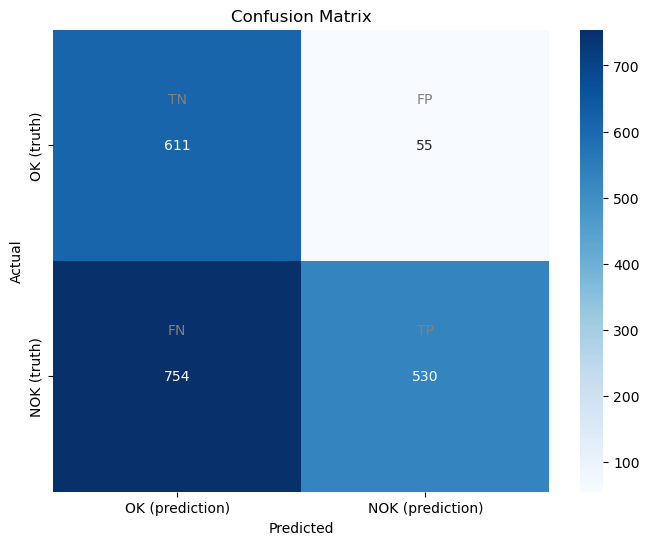


Confusion matrix logged at c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\CWRU\scene_1\train\(gearbox)\(gearbox)_fault_detector_3


In [9]:
trainer.confusion_matrix()

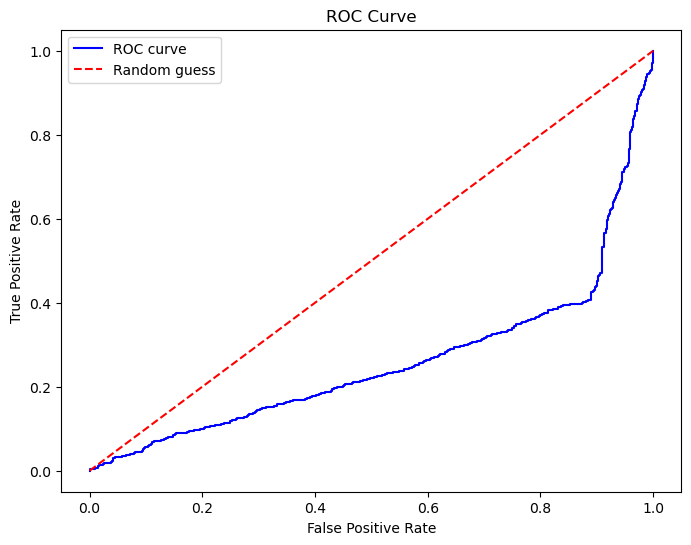

In [11]:
trainer.roc_curve()

### Test model

In [9]:
from settings.manager import get_model_pickle_path

# load trained model
trained_anomaly_detector = AnomalyDetector.load_from_pickle(get_model_pickle_path(train_log_path))

# update its data stats
trained_anomaly_detector.data_stats = test_data_stats

# initialize logger for testing
if fdet_config.is_log:
    test_logger = SummaryWriter(log_dir=fdet_config.get_test_log_path())
else:
    test_logger = None

# initialize tester
tester = TrainerAnomalyDetector(logger=test_logger)
tester.test(trained_anomaly_detector, test_loader)


Test accuracy: 0.96


## Custom Test

In [8]:
# new data
data_config.set_custom_test_dataset()

custom_test_data = data_preprocessor.get_custom_data(data_config)

custom_test_loader = custom_test_data[0]
custom_test_data_stats = custom_test_data[1]

Total samples: 12168, Desired samples: 7300, Remainder samples: 4868


In [9]:
from settings.manager import AnomalyDetectorPredictManager
import inspect
pred_config = AnomalyDetectorPredictManager(data_config)

trained_anomaly_detector = AnomalyDetector.load_from_pickle(pred_config.ckpt_path)

anomaly_detector.data_stats = custom_test_data_stats

In [10]:
from detector import TrainerAnomalyDetector
from torch.utils.tensorboard import SummaryWriter

custom_test_log_path = pred_config.get_custom_test_log_path()

# initialize logger
if fdet_config.is_log:
    pred_config.save_custom_test_params()
    logger = SummaryWriter(custom_test_log_path)
else:
    logger = None

# initialize trainer
tester = TrainerAnomalyDetector(logger=logger)
tester.test(trained_anomaly_detector, custom_test_loader)

custom_test number 1 for already exists for (gearbox)_fault_detector_7 in the log path 
'c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\custom_test\(gearbox)
\(gearbox)_fault_detector_7\(gearbox)_custom_test_1'.

Overwrote version 1 from the log path 
c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\custom_test\(gearbox)\
(gearbox)_fault_detector_7\(gearbox)_custom_test_1.

Custom test parameters saved to 
c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\custom_test\(gearbox)\
(gearbox)_fault_detector_7\(gearbox)_custom_test_1.

Test accuracy: 0.99


## Other stuff

In [1]:
import sys
import os
import torch

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
import os
from data.config import DataConfig
from settings.manager import AnomalyDetectorTrainManager

data_config = DataConfig(run_type="custom_test")
fdet_config = AnomalyDetectorTrainManager(data_config)

log_path = fdet_config.get_train_log_path(600, 1)
print(log_path)

if log_path is not None:
    os.makedirs(log_path, exist_ok=True)

fdet_config.save_params()

'Version 1' already exists in the log path 
'c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\train\(1_gearbox)\(1_
gearbox)_fault_detector_1'.

Next model number folder will be: (1_gearbox)_fault_detector_10

c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\train\(1_gearbox)\(1_gearbox)_fault_detector_10


Model parameters saved to 
c:\Aryan_Savant\Thesis_Projects\my_work\AFD_thesis\fault_detection\logs\bearing\cwru\scene_1\train\(1_gearbox)\(1_g
earbox)_fault_detector_10.

predict

In [3]:
import os
from data.config import DataConfig
from fault_detection.config import PredictAnomalyDetectorConfig

fdet_config = PredictAnomalyDetectorConfig()

data_config = DataConfig()
data_config.set_predict_dataset()

log_path = fdet_config.get_predict_log_path()
print(log_path)

if log_path is not None:
    os.makedirs(log_path, exist_ok=True)

fdet_config.save_predict_params()

c:\AFD\fault_detection\logs\bearing\cwru\scene_1\predict\(gearbox)\(gearbox)_fault_detector_1\(gearbox)_predict_1
Predict parameters saved to c:\AFD\fault_detection\logs\bearing\cwru\scene_1\predict\(gearbox)\(gearbox)_fault_detector_1\(gearbox)_predict_1.


test

In [2]:
import os
from data.config import DataConfig
from fault_detection.config import PredictAnomalyDetectorConfig

fdet_config = PredictAnomalyDetectorConfig()

data_config = DataConfig()
data_config.set_custom_test_dataset()

log_path = fdet_config.get_custom_test_log_path()
print(log_path)

if log_path is not None:
    os.makedirs(log_path, exist_ok=True)

fdet_config.save_custom_test_params()


custom_test number 1 for already exists for (gearbox)_fault_detector_1 in the log path 'c:\AFD\fault_detection\logs\bearing\cwru\scene_1\custom_test\(gearbox)\(gearbox)_fault_detector_1\(gearbox)_custom_test_1'.
Removed version 1 from the log path c:\AFD\fault_detection\logs\bearing\cwru\scene_1\custom_test\(gearbox)\(gearbox)_fault_detector_1\(gearbox)_custom_test_1.
c:\AFD\fault_detection\logs\bearing\cwru\scene_1\custom_test\(gearbox)\(gearbox)_fault_detector_1\(gearbox)_custom_test_1
Custom test parameters saved to c:\AFD\fault_detection\logs\bearing\cwru\scene_1\custom_test\(gearbox)\(gearbox)_fault_detector_1\(gearbox)_custom_test_1.


In [3]:
from fault_detection.config import SelectFaultDetectionModel

model_selector = SelectFaultDetectionModel(run_type="train")
                                           
model_selector.select_model_and_params()

bearing
└── cwru
    └── scene_1 (trained models)
        ├── <node_name>
        └── (gearbox)
            ├── <ds_type>
            └── healthy_unhealthy
                ├── <ds_subtype>
                └── 0_N[OG, gau_m=0.1s=0.2, gau_m=0.2s=0.3] + 0_B-007[gau_m=0.0s=0.1, gau_m=0.1s=0.2] + 0_B-021[OG]
                    ├── <model>
                    └── [anom] IF
                        ├── <ds_stats>
                        └── T500 [acc]
                            ├── <domain>
                            └── time
                                ├── <fex_type>
                                ├── (anom) [first_n_modes]
                                │   ├── <shape_compatibility>
                                │   └── anom (comps = 500)
                                │       ├── <versions>
                                │       └── (gearbox)_fault_detector_1 (v1) [0]
                                └── (anom) [no_fex]
                                    ├── <shape_compatibility>
                                    └── anom (comps = 500)
                                        ├── <versions>
                                        └── (gearbox)_fault_detector_2 (v1) [1]


Available version paths:
0: c:\AFD\fault_detection\logs\bearing\cwru\scene_1\train\(gearbox)\(gearbox)_fault_detector_1
1: c:\AFD\fault_detection\logs\bearing\cwru\scene_1\train\(gearbox)\(gearbox)_fault_detector_2


ValueError: invalid literal for int() with base 10: ''